In [18]:
import cv2
import torch
import segment_anything
from segment_anything import SamPredictor, sam_model_registry
import matplotlib.pyplot as plt
import gzip
from utils import *
from testing import test_model
from dataset import BTCV2DSliceDataset, BTCV2DSlicePromptDataset,to_uint8_rgb, remove_pure_background, to_tensor
from torch.utils.data import DataLoader
from prompt_gen import *
import nibabel as nib
import json

In [19]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

device

device(type='mps')

In [3]:
sam = sam_model_registry['default']('./sam_vit_h_4b8939.pth')
sam.to(device)
predictor = SamPredictor(sam)

# Test SAM on single image

In [5]:
image = cv2.imread('./images/Dog.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [8]:
image.shape

(1365, 2048, 3)

In [9]:
predictor.set_image(image)

In [10]:
input_point = np.array([[1200, 800], [1000,700]])
input_label = np.array([1, 1])

In [11]:
masks, scores, logits = predictor.predict(
    point_coords=input_point, 
    point_labels=input_label,
    multimask_output=True,
)

In [12]:
masks

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, Fal

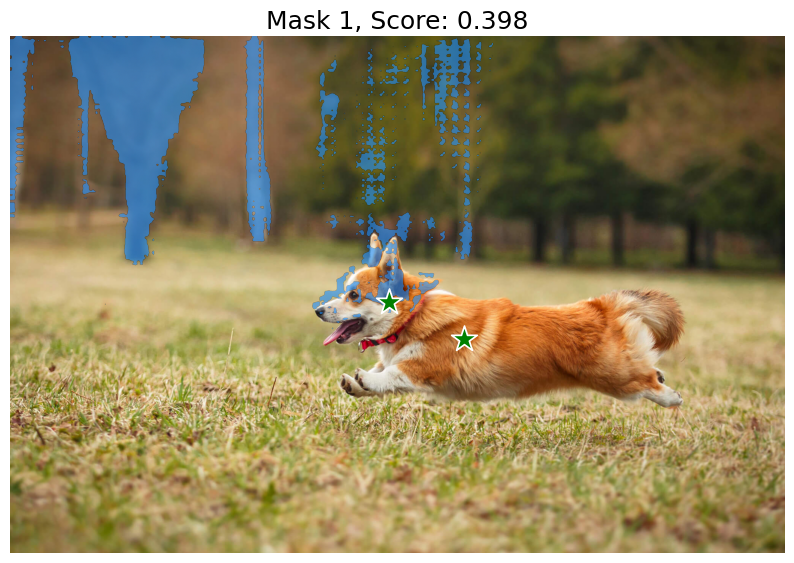

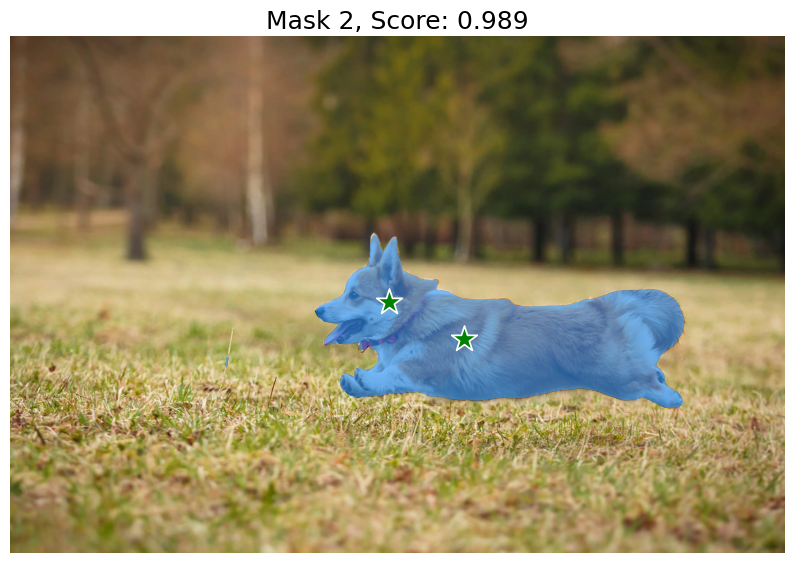

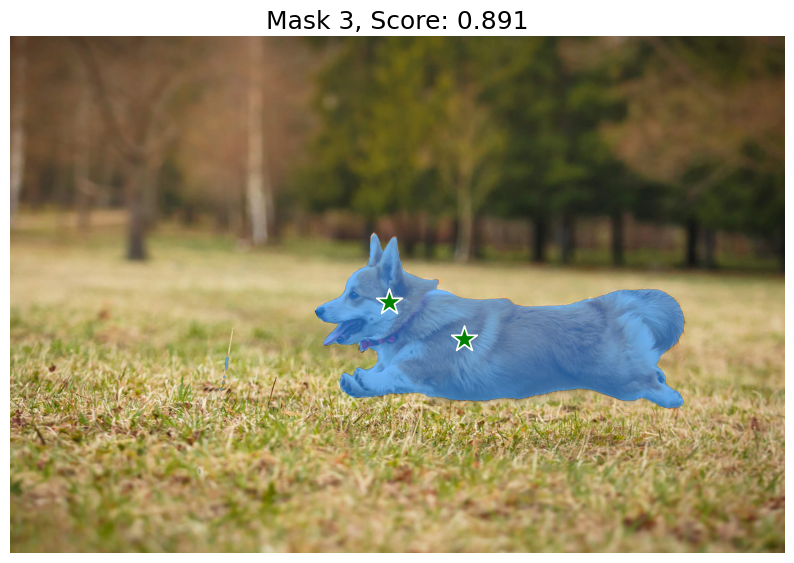

In [13]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  

In [14]:
input_box = np.array([750, 450, 1800, 1000])

masks, _, _ = predictor.predict(box = input_box[None, :])

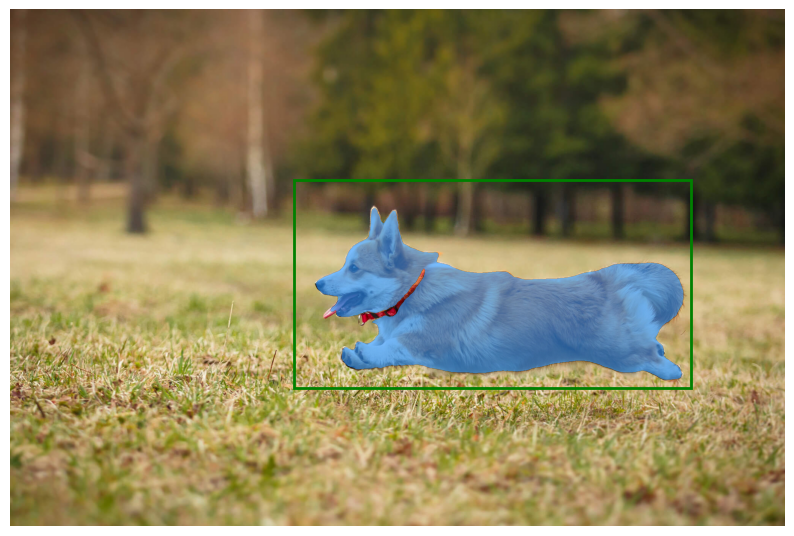

In [15]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()

## Test batched point prompt

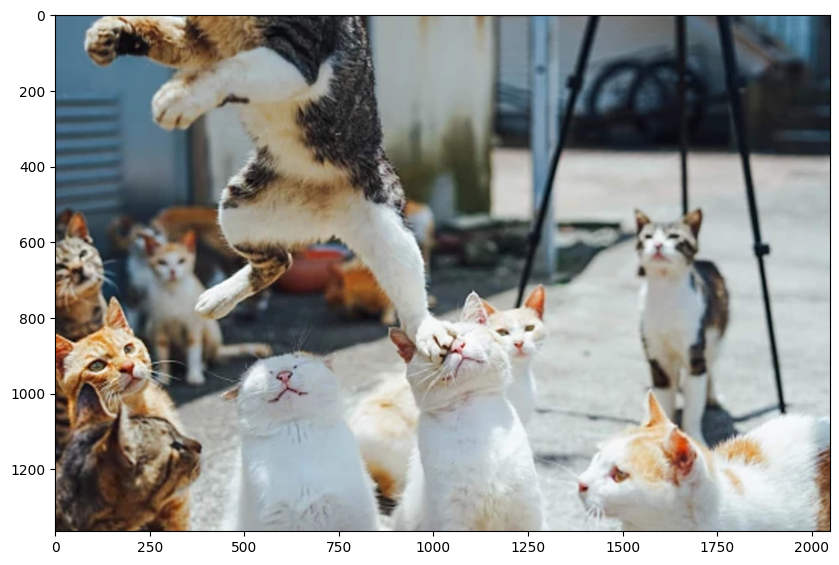

In [8]:
cats = cv2.imread('./images/Cats.jpeg')
cats = cv2.cvtColor(cats, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,10))
plt.imshow(cats)
plt.axis('on')
plt.show()

In [9]:
predictor.set_image(cats)

In [18]:
input_points = np.array([[[750, 400], [600, 200]], [[750, 1200], [600, 1000]]])
input_labels = np.array([[1, 1], [1, 1]])

In [19]:
print(input_points.shape, input_labels.shape)

(2, 2, 2) (2, 2)


## Visualize BTCV Dataset

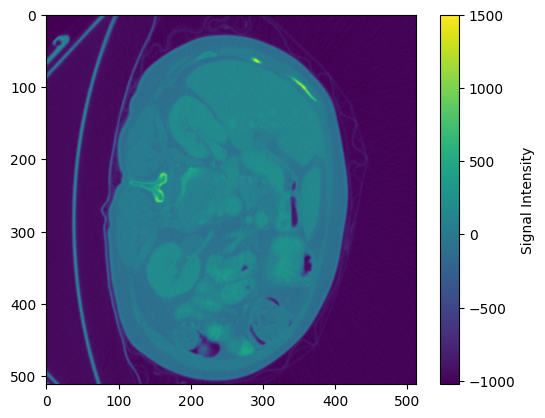

In [16]:
img = nib.load('./data/imagesTr/img0001.nii.gz').get_fdata()

plt.imshow(img[:, :, 100])
plt.colorbar(label='Signal Intensity')

# Test box prompt generation

In [4]:
preprocess = lambda images, labels: to_tensor(*to_uint8_rgb(*remove_pure_background(images, labels)))

train_set = BTCV2DSliceDataset(root_dir='./data', 
                               json_file='./data/dataset_0.json', 
                               type='training', 
                               preprocess=preprocess)
validation_set = BTCV2DSliceDataset(root_dir='./data', 
                               json_file='./data/dataset_0.json', 
                               type='validation', 
                               preprocess=preprocess)

In [22]:
validation_loader = DataLoader(validation_set, batch_size=1, shuffle=False)

In [23]:
len(validation_loader)

408

In [24]:
batch = next(iter(validation_loader))
boxes = box_prompt(batch['label'], device=device)

In [25]:
boxes

[{9: tensor([274, 236, 291, 264], device='mps:0')}]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


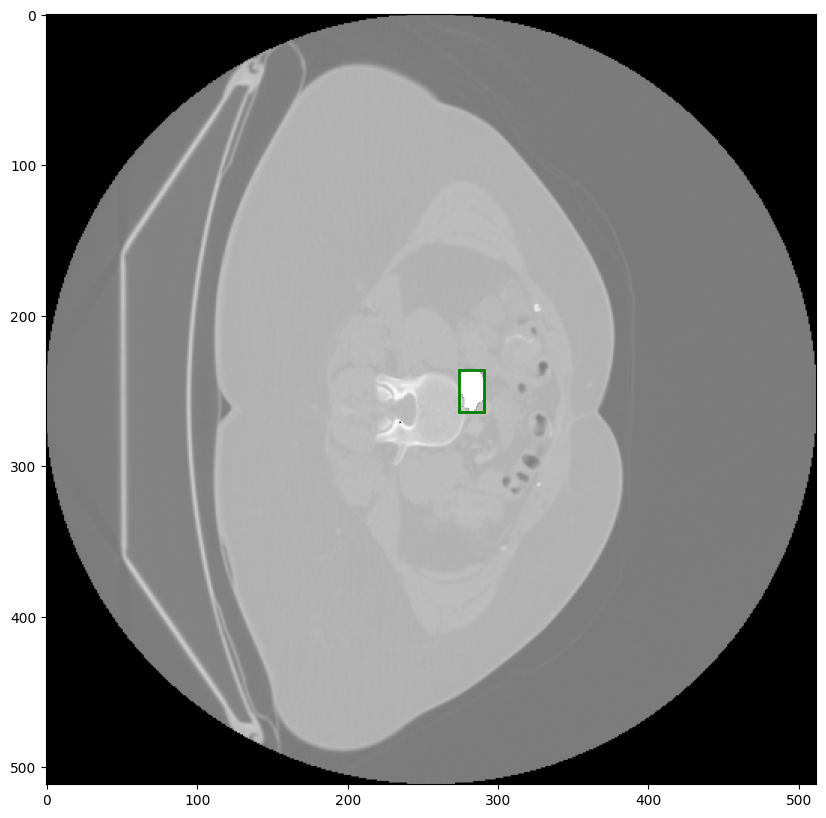

In [26]:
img = batch['image']

for i in range(img.shape[0]):
    plt.figure(figsize=(10,10))
    plt.imshow(img[i])

    show_mask(batch['label'][i], plt.gca())

    bbox = boxes[i]

    for k, b in bbox.items():
        show_box(b.cpu().numpy(), plt.gca())

# Test box input for validation dataset

In [5]:
validation_loader = DataLoader(validation_set, batch_size=1, shuffle=False)

In [30]:
import tqdm

total_intersection = dict()  # organ_id -> total intersect pixels
total_mask_pixels = dict()   # organ_id -> total mask pixels

# Dice = 2 * intersect / total mask pixels 
# mDice = Average Dice over all categories

for batched_data in tqdm.tqdm(validation_loader):
    images, labels = batched_data['image'], batched_data['label'] # labels transferred to mps will cause strange errors
    batch_size = images.shape[0]
    bboxes = box_prompt(labels, device=device)
    batched_input = batched_input_gen(images, bboxes, ['box'] * batch_size, sam)
    batched_output = sam(batched_input, multimask_output=False)

    for img_idx in range(batch_size):
        # for every input image
        output = batched_output[img_idx]
        for box_idx, gt_label in enumerate(bboxes[img_idx].keys()):
            # for every bounding box in the image
            gt_mask = (labels[img_idx] == gt_label).cpu()
            pred_mask = output['masks'][box_idx].cpu()

            intersection = torch.sum(torch.logical_and(gt_mask ,pred_mask)).item()
            total_pixels = torch.sum(gt_mask).item() + torch.sum(pred_mask).item()

            total_intersection.setdefault(gt_label, 0)
            total_mask_pixels.setdefault(gt_label, 0)

            total_intersection[gt_label] += intersection
            total_mask_pixels[gt_label] += total_pixels 

dice = dict([(organ_id , 2 * total_intersection[organ_id] / total_mask_pixels[organ_id]) for organ_id in total_intersection])
mDice = np.mean(list(dice.values()))

100%|██████████| 408/408 [33:41<00:00,  4.96s/it]


In [31]:
mDice

0.7584724670827128

In [32]:
dice

{9: 0.9025318571667373,
 8: 0.8308245679807033,
 6: 0.8565980021071065,
 2: 0.9303768496799304,
 3: 0.9340228087842971,
 1: 0.9089565733062422,
 11: 0.6832838405333894,
 7: 0.7833670571452539,
 13: 0.7377525650453479,
 10: 0.26171577829533443,
 12: 0.6397041614005523,
 5: 0.8175510164248002,
 4: 0.5734569942055717}

In [5]:
validation_loader = DataLoader(validation_set, batch_size=1, shuffle=True)
iter_loader = iter(validation_loader)

visualize some of the predictions

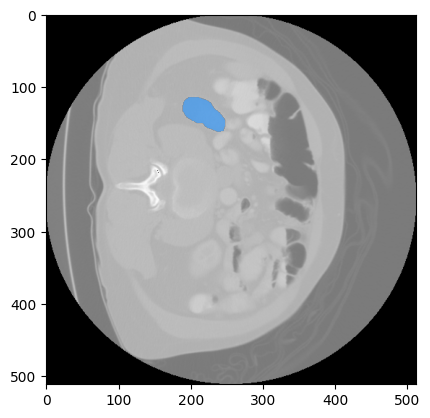

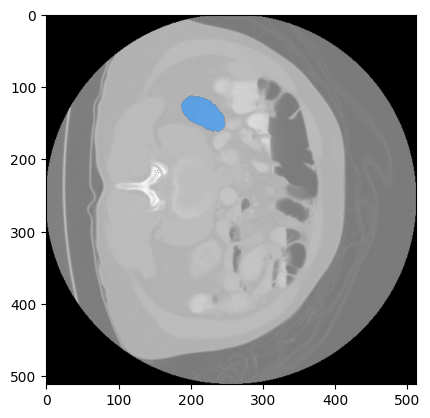

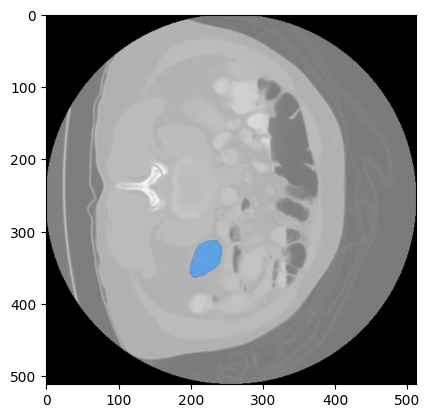

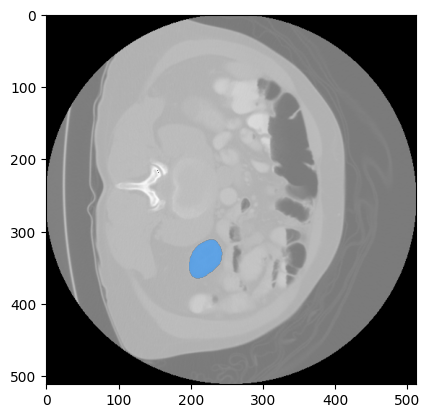

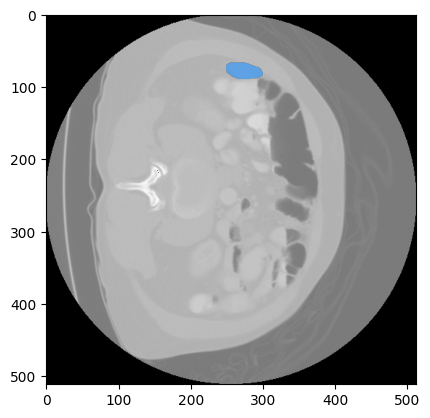

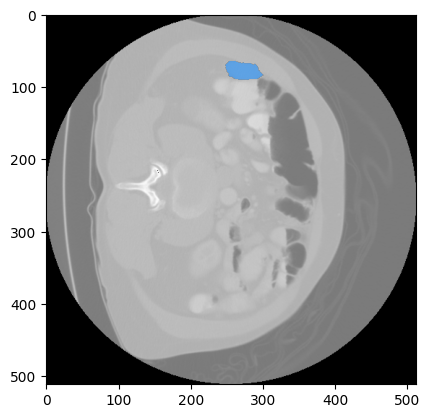

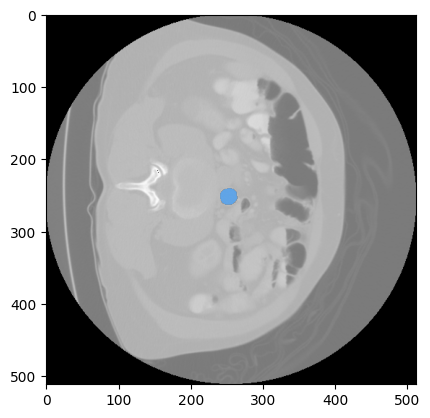

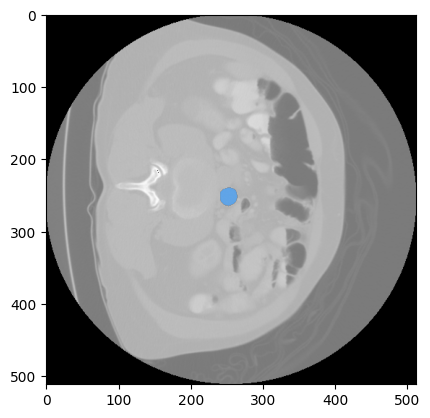

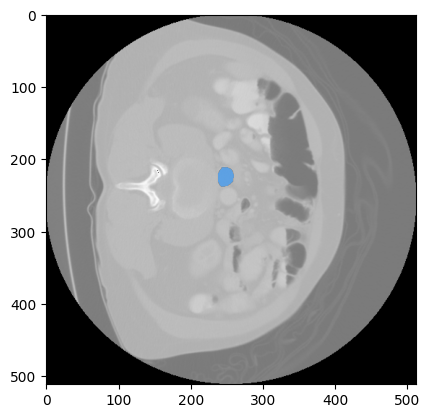

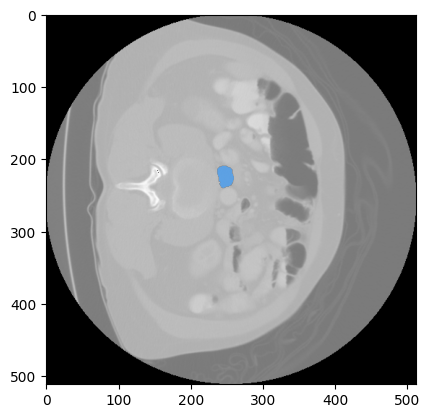

In [6]:
batched_data = next(iter_loader)

images, labels = batched_data['image'], batched_data['label'] # labels transferred to mps will cause strange errors
batch_size = images.shape[0]
bboxes = box_prompt(labels, device=device)
batched_input = batched_input_gen(images, bboxes, ['box'] * batch_size, sam)
batched_output = sam(batched_input, multimask_output=False)

for img_idx in range(batch_size):
    # for every input image
    output = batched_output[img_idx]
    for box_idx, gt_label in enumerate(bboxes[img_idx].keys()):
        # for every bounding box in the image
        gt_mask = (labels[img_idx] == gt_label).cpu().numpy()
        pred_mask = output['masks'][box_idx].cpu().numpy()

        plt.figure()
        plt.imshow(images[img_idx])
        show_mask(gt_mask, plt.gca())
        plt.show()
        plt.figure()
        plt.imshow(images[img_idx])
        show_mask(pred_mask[0], plt.gca())
        plt.show()

# Test point prompt for validation dataset

In [8]:
validation_loader = DataLoader(validation_set, batch_size=1, shuffle=True)

In [9]:
batch = next(iter(validation_loader))

In [15]:
labels = batch['label']
pprompt = point_prompt(labels, 3, device=device, single_prompt=True)
pprompt

[{8: tensor([[309, 268],
          [265, 289],
          [201, 298]], device='mps:0')}]

In [16]:
len(pprompt[0])

1

In [17]:
img = batch['image']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


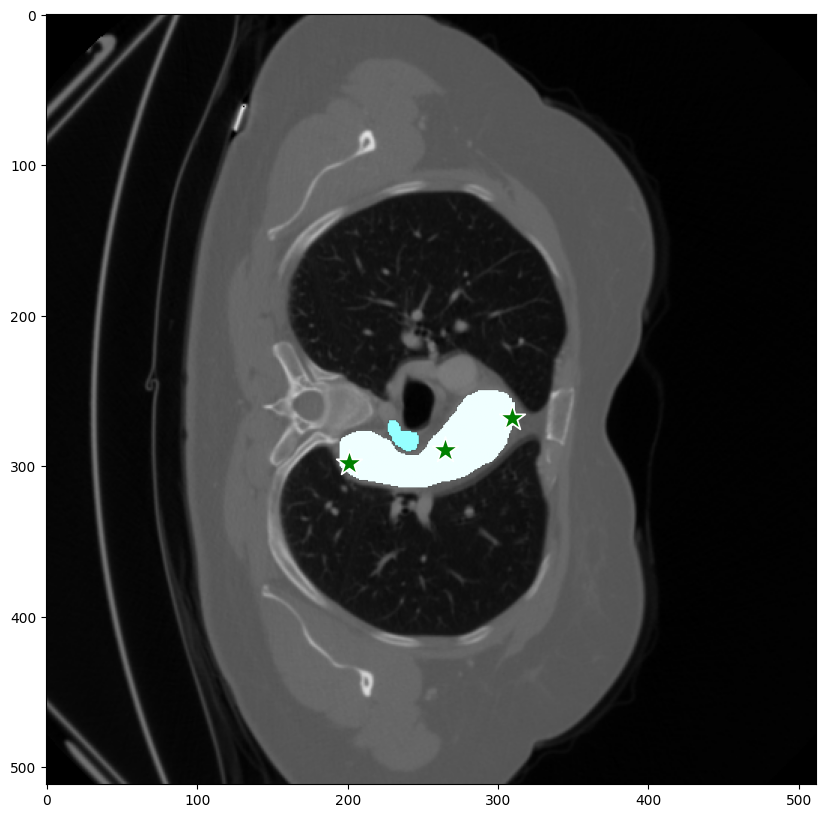

In [18]:
for i in range(img.shape[0]):
    plt.figure(figsize=(10, 10))

    plt.imshow(img[i])
    show_mask(batch['label'][i], plt.gca())

    points = torch.vstack(list(pprompt[i].values())).cpu().numpy()
    show_points(points, np.array([1] * points.shape[0]), plt.gca())

In [ ]:
validation_loader = DataLoader(validation_set, batch_size=1, shuffle=False)
dice, mDice = test_model(validation_loader, lambda labels, device: point_prompt(labels, 1, device), 'point', sam)

# Fine-tuning model on BTCV Dataset

batched_output: list of dictionaries with keys 'masks', 'iou_predictions', 'low_res_logits'

convert low res logits to mask logits: 

sam.postprocess_masks(batched_output[0]['low_res_logits'], batched_input[0]['image'].shape[-2:], 
                      batched_input[0]['original_size'])

In [5]:
from sam_btcv import SamBTCV 
from metric import *
from training import *
from torch.optim import AdamW

model = SamBTCV(sam, requires_classification=True)

In [10]:
optimizer = AdamW(model.mask_decoder.parameters(), lr=8e-4, betas=(0.9, 0.999), weight_decay=0.1)

In [11]:
train_one_epoch(train_set, optimizer, model, 16)

mse loss: 0.5435543656349182
focal loss: 0.6443522572517395
dice loss: 0.7331820726394653
cross entropy loss: 2.631004571914673
total_loss: 16.79478645324707
mse loss: 0.20566914975643158
focal loss: 0.003573155729100108
dice loss: 0.7598797082901001
cross entropy loss: 2.6049747467041016
total_loss: 3.641986846923828
mse loss: 0.04139220714569092
focal loss: 0.1362859308719635
dice loss: 0.907616376876831
cross entropy loss: 2.6199593544006348
total_loss: 6.294686317443848
mse loss: 0.0875968486070633
focal loss: 0.013184988871216774
dice loss: 0.8524320125579834
cross entropy loss: 2.4803428649902344
total_loss: 3.6840715408325195
mse loss: 0.07881226390600204
focal loss: 0.013877378776669502
dice loss: 0.9515204429626465
cross entropy loss: 2.5297577381134033
total_loss: 3.8376379013061523
mse loss: 0.030993031337857246
focal loss: 0.0019453982822597027
dice loss: 0.8506776094436646
cross entropy loss: 2.607728958129883
total_loss: 3.5283074378967285
mse loss: 0.028914641588926315
f

# Test SAM model as a classifier

In [23]:
import json 
import nibabel as nib
import os 
from segment_anything import sam_model_registry
from sam_btcv import SamBTCV
from dataset import to_uint8_rgb, remove_pure_background, to_tensor
from segment_anything.utils.transforms import ResizeLongestSide
from utils import *

with open('./data/dataset_0.json', 'r') as f:
    dataset_info = json.load(f)

dataset_info['validation']

[{'image': 'imagesTr/img0035.nii.gz', 'label': 'labelsTr/label0035.nii.gz'},
 {'image': 'imagesTr/img0036.nii.gz', 'label': 'labelsTr/label0036.nii.gz'},
 {'image': 'imagesTr/img0037.nii.gz', 'label': 'labelsTr/label0037.nii.gz'},
 {'image': 'imagesTr/img0038.nii.gz', 'label': 'labelsTr/label0038.nii.gz'},
 {'image': 'imagesTr/img0039.nii.gz', 'label': 'labelsTr/label0039.nii.gz'},
 {'image': 'imagesTr/img0040.nii.gz', 'label': 'labelsTr/label0040.nii.gz'}]

In [25]:
sam = sam_model_registry['default']('./sam_vit_h_4b8939.pth')
sam.to(device)
model = SamBTCV(sam, requires_classification=True)

resize_transform = ResizeLongestSide(model.image_encoder.img_size)

In [29]:
preprocess = lambda images, labels: to_uint8_rgb(*remove_pure_background(images, labels))

points_along_side = 32
predicted_labels = []

for data in dataset_info['validation']:
    images = nib.load(os.path.join('./data', data['image'])).get_fdata()
    labels = nib.load(os.path.join('./data', data['label'])).get_fdata()

    images, labels = preprocess(images, labels) # [B, H, W, C]

    original_size = images.shape[1 : 3]

    xs = np.linspace(0, original_size[1], points_along_side, dtype=np.uint32).reshape((-1, 1))
    ys = np.linspace(0, original_size[0], points_along_side, dtype=np.uint32).reshape((-1, 1))

    # shape of point_grid should be [N, 1, 2]
    point_grid = np.hstack([xs, ys])[:, None, :]  
    point_coords = resize_transform.apply_coords(point_grid, original_size)
    point_labels = np.ones(point_coords.shape[: 2], dtype = point_coords.dtype)

    predicted_labels.append([])

    for image, label in zip(images, labels):
        # image: torch.Tensor [H, W, C]
        image = prepare_image(image, resize_transform, model.device)

        input = [{'image' : image, 'original_size' : original_size, 
                 'point_coords' : torch.tensor(point_coords, dtype=torch.float32 , device=model.device), 
                 'point_labels' : torch.tensor(point_labels, dtype=torch.float32, device=model.device)}]
        
        output = model(input, False)[0]
        predicted_labels[-1].append(predict_labels(output))
        


In [1]:
@torch.no_grad()
def predict_labels(output, iou_thresh : float = 0.5):
    """
    Args:
    output: dictionary with keys 'masks', 'iou_predictions', 'low_res_logits', 'class_predictions'
                'masks': (torch.Tensor) Batched binary mask predictions,
                 with shape BxCxHxW, where B is the number of input prompts,
                 C is determined by multimask_output, and (H, W) is the
                 original size of the image.
                'iou_predictions': (torch.Tensor) The model's predictions
                 of mask quality, in shape BxC.
                'low_res_logits': (torch.Tensor) Low resolution logits with
                shape BxCxHxW, where H=W=256. Can be passed as mask input
                to subsequent iterations of prediction.
                'class_predictions': (torch.Tensor) BxCxn_classes, logits

    Returns:
    predicted labels: [H, W]
    """
    masks = output['masks'][:, 0, :, :]
    predicted_labels = torch.zeros(masks.shape[2:], dtype=torch.uint8)
    iou_predictions = output['iou_predictions'].view(-1)
    class_predictions = output['class_predictions'][:, 0, :]


    permutation = torch.argsort(iou_predictions, descending=True)
    iou_predictions = iou_predictions[permutation]
    class_predictions = torch.argmax(class_predictions[permutation, :], dim=1)
    masks = masks[permutation]

    for iou, organ_pred, mask in zip(iou_predictions, class_predictions, mask):
        iou = iou.item()
        organ_pred = organ_pred.item()

        if organ_pred in organ_id_to_mask:
            continue 

        # check if overlapped with other masks (IoU > threshold)
        overlapped = False
        for _, m in organ_id_to_mask.values():
            intersection = torch.sum(torch.logical_and(m, mask)).sum().item()
            union = torch.sum(torch.logical_or(m, mask)).sum().item()

            if intersection / union > iou_thresh:
                overlapped = True
                break 

        if overlapped:
            continue 

        predicted_labels[torch.logical_and(predicted_labels == 0, mask)] = organ_pred
    
    return predicted_labels